In [21]:
import csv

In [26]:
with open('scores.csv') as csvfile:
    rows = csv.reader(csvfile)
    res = list(zip(*rows))
    res = res[-2:]

In [33]:
names = res[0][3:45]
points = res[1][3:45]

In [49]:
scoresDict = {"scores": []}
scoresZip = zip(names, points)
for item in scoresZip:
    scoresDict["scores"].append({"name": item[0], "points": int(item[1])})

In [50]:
scoresDict

{'scores': [{'name': 'Lukas Frösslund', 'points': 4},
  {'name': 'Jennifer Johansson', 'points': 4},
  {'name': 'Albin Thurén', 'points': 4},
  {'name': 'Erik Gustafsson', 'points': 4},
  {'name': 'Cajsa Eriksson', 'points': 4},
  {'name': 'Patric Hjorth', 'points': 4},
  {'name': 'Jacob Hjorth', 'points': 4},
  {'name': 'Andreas Eriksson', 'points': 4},
  {'name': 'Anton Wårdell', 'points': 4},
  {'name': 'David Berg', 'points': 4},
  {'name': 'Ted Karlsson', 'points': 4},
  {'name': 'Alexander Jarlenäs', 'points': 4},
  {'name': 'Hedvig Fahlstedt', 'points': 4},
  {'name': 'Adam de Lancey', 'points': 4},
  {'name': 'Tor Simmons', 'points': 4},
  {'name': 'Noel Milleskog', 'points': 4},
  {'name': 'Hanna Milleskog', 'points': 4},
  {'name': 'Rickard Brånemark', 'points': 4},
  {'name': 'William Laahanen', 'points': 2},
  {'name': 'Adam Laahanen', 'points': 2},
  {'name': 'Johannes Karlsson', 'points': 2},
  {'name': 'Filip Lidhammar', 'points': 2},
  {'name': 'William Magnusson', 'poi

In [40]:
import json

In [59]:
with open('scores.json', 'w') as f:
    json.dump(scoresDict, f, ensure_ascii=False)

In [58]:
json_string

'{"scores": [{"name": "Lukas Frösslund", "points": 4}, {"name": "Jennifer Johansson", "points": 4}, {"name": "Albin Thurén", "points": 4}, {"name": "Erik Gustafsson", "points": 4}, {"name": "Cajsa Eriksson", "points": 4}, {"name": "Patric Hjorth", "points": 4}, {"name": "Jacob Hjorth", "points": 4}, {"name": "Andreas Eriksson", "points": 4}, {"name": "Anton Wårdell", "points": 4}, {"name": "David Berg", "points": 4}, {"name": "Ted Karlsson", "points": 4}, {"name": "Alexander Jarlenäs", "points": 4}, {"name": "Hedvig Fahlstedt", "points": 4}, {"name": "Adam de Lancey", "points": 4}, {"name": "Tor Simmons", "points": 4}, {"name": "Noel Milleskog", "points": 4}, {"name": "Hanna Milleskog", "points": 4}, {"name": "Rickard Brånemark", "points": 4}, {"name": "William Laahanen", "points": 2}, {"name": "Adam Laahanen", "points": 2}, {"name": "Johannes Karlsson", "points": 2}, {"name": "Filip Lidhammar", "points": 2}, {"name": "William Magnusson", "points": 2}, {"name": "Hugo Arvidsson", "point

In [1]:
import pandas as pd 

In [47]:
sheetList = [{'name': 'Lukas Frösslund', 'points': 2054910135},
  {'name': 'Jennifer Johansson', 'points': 367674404},
  {'name': 'Albin Thurén', 'points': 351386624},
  {'name': 'Erik Gustafsson', 'points': 1356020415},
  {'name': 'Cajsa Eriksson', 'points': 1763715858},
  {'name': 'Patric Hjorth', 'points': 956825562},
  {'name': 'Jacob Hjorth', 'points': 1623203222},
  {'name': 'Andreas Eriksson', 'points': 1249302655},
  {'name': 'Anton Wårdell', 'points': 396050143},
  {'name': 'David Berg', 'points': 1688944588},
  {'name': 'Ted Karlsson', 'points': 861631264},
  {'name': 'Alexander Jarlenäs', 'points': 1095748200},
  {'name': 'Hedvig Fahlstedt', 'points': 1876713390},
  {'name': 'Adam de Lancey', 'points': 942871444},
  {'name': 'Tor Simmons', 'points': 135785318},
  {'name': 'Noel Milleskog', 'points': 773274216},
  {'name': 'Hanna Milleskog', 'points': 866646381},
  {'name': 'Rickard Brånemark', 'points': 315893603},
  {'name': 'William Laahanen', 'points': 1314708184},
  {'name': 'Adam Laahanen', 'points': 2141502958},
  {'name': 'Johannes Karlsson', 'points': 101737574},
  {'name': 'Filip Lidhammar', 'points': 1572752502},
  {'name': 'William Magnusson', 'points': 268517332},
  {'name': 'Hugo Arvidsson', 'points': 550474824},
  {'name': 'Robert Lidhammar', 'points': 1965949287},
  {'name': 'Viktor Hansson', 'points': 1062474688},
  {'name': 'Isabella Johannesson', 'points': 1631251563},
  {'name': 'Pontus Lundgren', 'points': 220966450},
  {'name': 'Oscar Andersson', 'points': 1670072045},
  {'name': 'Kenneth Runnman', 'points': 2108224413},
  {'name': 'Patricia Correia', 'points': 955752933},
  {'name': 'Amanda Nilsson', 'points': 46684960},
  {'name': 'Alicia Brånemark', 'points': 2022670665},
  {'name': 'Filip Mälberg', 'points': 279112572},
  {'name': 'Jonny Frösslund', 'points': 2103240923},
  {'name': 'Joel Fahlstedt', 'points': 98219501},
  {'name': 'Anna Brånemark', 'points': 42437357},
  {'name': 'Per Kivijärvi', 'points': 855220829},
  {'name': 'Valdemar Gezelius', 'points': 1651765570},
  {'name': 'Sebastian Brånemark', 'points': 696325482},
  {'name': 'Linnéa Amundson', 'points': 1950141069},
  {'name': 'Andreas Schill', 'points': 1576817809}]

In [49]:
from tqdm import tqdm

In [53]:
dfStats = {}
completeSpreadsheetIdx = "1yAKozFLtn03rTj9ByB0aulmebP0_U1TAsGz538zAY0w"
for sheet in tqdm(sheetList):
    participant = sheet['name']
    sheet_idx = sheet['points']
    dfStats[sheet_idx] = {}
    dfStats[sheet_idx]['name'] = participant

    url = f"https://docs.google.com/spreadsheets/d/{completeSpreadsheetIdx}/export?format=csv&gid={sheet_idx}"
    curr_df = pd.read_csv(url)

    dfStats[sheet_idx]['winner'] = curr_df.iloc[2, 23]
    dfStats[sheet_idx]['topscorer'] = curr_df.iloc[3, 23]
    
    dfStats[sheet_idx]['matches'] = []
    match_idx = 2
    while match_idx <= 52:
        for i in range(6):
            dfStats[sheet_idx]['matches'].append([curr_df.iloc[match_idx, 6], str(int(curr_df.iloc[match_idx, 8])), curr_df.iloc[match_idx, 9]])
            match_idx += 1
        match_idx += 3
    
    dfStats[sheet_idx]['roundofsixteen'] = []
    match_idx = 56
    while match_idx <= 63:
        dfStats[sheet_idx]['roundofsixteen'].append(curr_df.iloc[match_idx, 3])
        dfStats[sheet_idx]['roundofsixteen'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    dfStats[sheet_idx]['quarterfinals'] = []
    match_idx = 67
    while match_idx <= 70:
        dfStats[sheet_idx]['quarterfinals'].append(curr_df.iloc[match_idx, 3])
        dfStats[sheet_idx]['quarterfinals'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    dfStats[sheet_idx]['semifinals'] = []
    match_idx = 74
    while match_idx <= 75:
        dfStats[sheet_idx]['semifinals'].append(curr_df.iloc[match_idx, 3])
        dfStats[sheet_idx]['semifinals'].append(curr_df.iloc[match_idx, 5])
        match_idx += 1
    
    dfStats[sheet_idx]['final'] = []
    dfStats[sheet_idx]['final'].append(curr_df.iloc[79, 3])
    dfStats[sheet_idx]['final'].append(curr_df.iloc[79, 5])


100%|██████████| 42/42 [01:36<00:00,  2.31s/it]


In [3]:
import pickle 

def dumpPickle(df, name):
    picklefile = open(name, 'wb')
    pickle.dump(df, picklefile)
    picklefile.close()
    print("Pickle dumped and picklefile closed.")


def loadPickle(name):
    picklefile = open(name, 'rb')
    df = pickle.load(picklefile)
    return df

In [56]:
dumpPickle(dfStats, "allStatsTips")

Pickle dumped and picklefile closed.


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
dfStats[42437357]['topscorer'] = 'Ronaldo'

In [72]:
topscorers = []
for key in dfStats.keys():
    topscorers.append(dfStats[key]['topscorer'])

In [73]:
topscorers

['Serge Gnabry',
 'Harry Kane',
 'Lukaku',
 'Cristiano Ronaldo',
 'Kylian Mbappé',
 'Kane',
 'Harry Kane',
 'Harry Kane',
 'Lukaku',
 'Ronaldo',
 'Romelu Lukaku',
 'Harry Kane',
 'Kylian Mbappé',
 'Harry Kane',
 'Benzema',
 'Griezmann ',
 'Mbpappe',
 'Grassman',
 'Memphis Depay',
 'Cristiano Ronaldo',
 'Mbappe',
 'Kylian Mbappe',
 'Lukaku',
 'Harry Kane',
 'Harry Kane',
 'Cristiano Ronaldo',
 'Harry Kane',
 'Romelu Lukaku',
 'Kylian Mbappé',
 'Romelu Lukau',
 'Cristiano Ronaldo',
 'Mbappe',
 'Alexander Isak ',
 'Lukaku',
 'Mbappe',
 'Bibimbap/ Mbappé',
 'Ronaldo',
 'Alexander Isak',
 'Harry Kane',
 'Romelu Lukaku',
 'Harry Kane',
 'Harry Kane']

In [12]:
topscorers = [('Harry Kane', 12), ('Kylian Mbappé', 9), ('Romelu Lukaku', 8), ('Cristiano Ronaldo', 6),  ('Alexander Isak', 2), ('Antoine Griezmann', 2), ('Memphis Depay', 1), ('Serge Gnabry', 1),  ('Karim Benzema', 1)]

' ax1.axhline(0, color="k", clip_on=False)\nax1.set_ylabel("Sequential") '

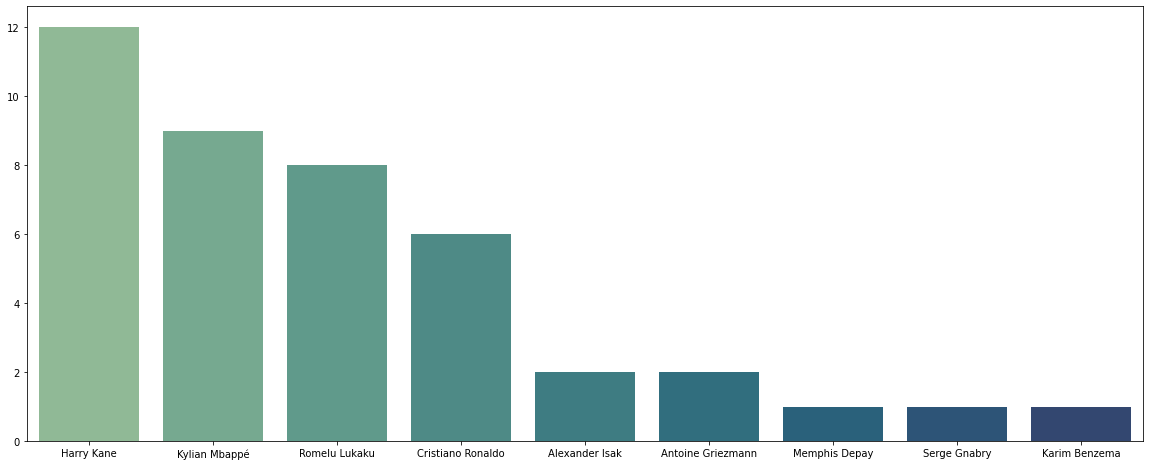

In [15]:
x = []
y = []
for player in topscorers:
    x.append(player[0])
    y.append(player[1])
x = np.array(x)
y = np.array(y)
dims = (20, 8)
fig, ax = plt.subplots(figsize=dims)
barp = sns.barplot(x=x, y=y, palette="crest", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="topscorers_plot")
""" ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential") """

In [4]:
df = loadPickle("allStatsTips")

In [9]:
winners = {}
for key in df.keys():
    winner = df[key]['winner']
    if winner in winners:
        winners[winner] += 1
    else:
        winners[winner] = 1

In [10]:
winners

{'Portugal': 4,
 'Frankrike': 20,
 'Italien': 4,
 'England': 3,
 'Belgien': 4,
 'Tyskland': 5,
 'Sverige': 2}

In [19]:
list(winners.values())

[4, 20, 4, 3, 4, 5, 2]

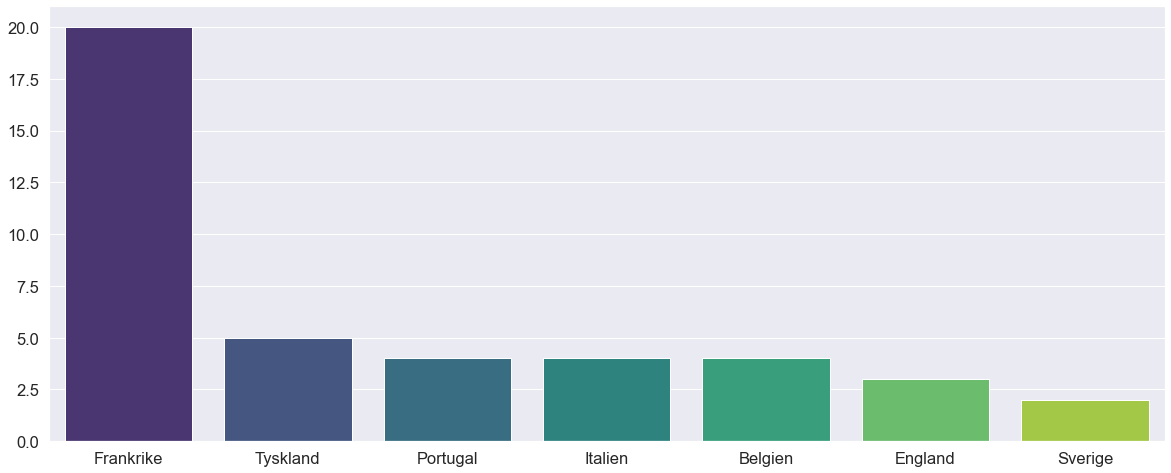

In [93]:

x = np.array(list(winners.keys()))
y = np.array(list(winners.values()))
dims = (20, 8)
fig, ax = plt.subplots(figsize=dims)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax, order=['Frankrike', 'Tyskland', 'Portugal', 'Italien', 'Belgien', 'England', 'Sverige'])
fig = barp.get_figure()
fig.savefig(dpi=300, fname="winners_plot_2")

In [29]:
scores = {}
signs = {}
for key in df.keys():
    r = df[key]['matches'][1]
    res = r[0] + "-" + r[1]
    s = r[2]
    if res in scores:
        scores[res] += 1
    else:
        scores[res] = 1
    if s in signs:
        signs[s] += 1
    else:
        signs[s] = 1 

In [30]:
scores

{'1-1': 20,
 '0-1': 5,
 '1-0': 1,
 '0-3': 1,
 '1-3': 2,
 '0-2': 2,
 '0-0': 2,
 '1-2': 7,
 '2-1': 1,
 '2-2': 1}

In [31]:
signs

{'X': 24, '1': 2, '2': 16}

In [32]:
signs = {'X': 23, '1': 2, '2': 17}

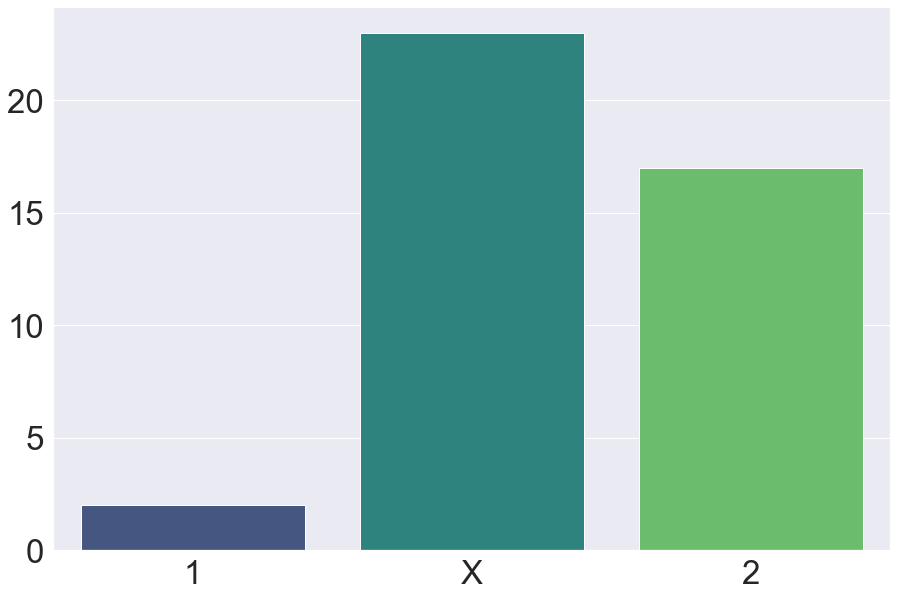

In [41]:
x = np.array(list(signs.keys()))
y = np.array(list(signs.values()))
dims = (15, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 3)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax, order=['1', 'X', '2'])
fig = barp.get_figure()
fig.savefig(dpi=300, fname="signs_plot_2")

In [34]:
sort_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [35]:
sort_scores

[('1-1', 20),
 ('1-2', 7),
 ('0-1', 5),
 ('1-3', 2),
 ('0-2', 2),
 ('0-0', 2),
 ('1-0', 1),
 ('0-3', 1),
 ('2-1', 1),
 ('2-2', 1)]

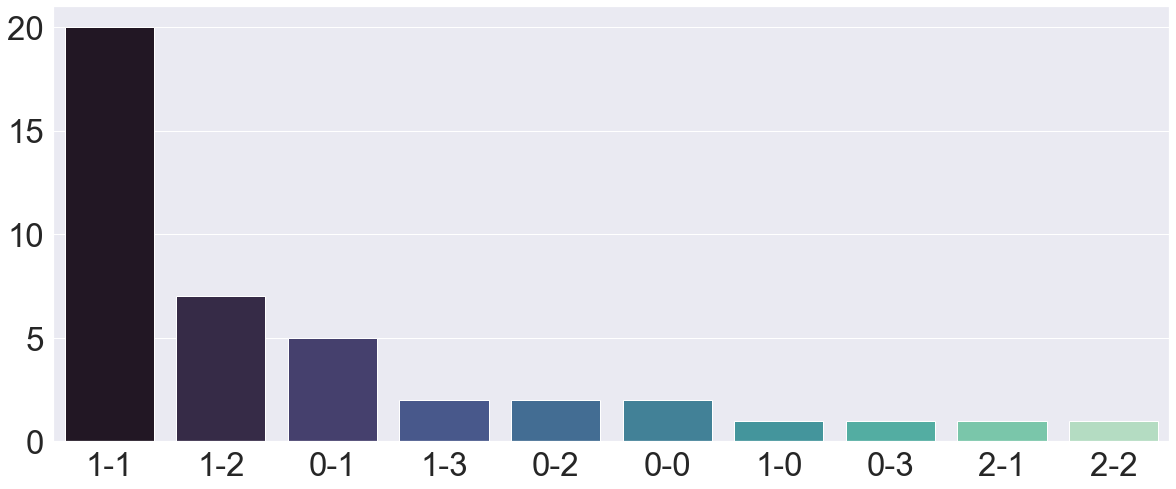

In [40]:
x = []
y = []
for val in sort_scores:
    x.append(val[0])
    y.append(val[1])
x = np.array(x)
y = np.array(y)
dims = (20, 8)
sns.set(font_scale = 3)
fig, ax = plt.subplots(figsize=dims)
barp = sns.barplot(x=x, y=y, palette="mako", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="scores_plot_2")

In [44]:
in_final = {}
for key in df.keys():
    finalTeams = df[key]['final']
    team_1, team_2 = finalTeams
    if team_1 in in_final:
        in_final[team_1] += 1
    else:
        in_final[team_1] = 1
    if team_2 in in_final:
        in_final[team_2] += 1
    else:
        in_final[team_2] = 1

In [45]:
in_final

{'Tyskland': 14,
 'Portugal': 15,
 'Frankrike': 27,
 'England': 10,
 'Italien': 7,
 'Spanien': 2,
 'Belgien': 5,
 'Sverige': 2,
 'Nederländerna': 2}

In [71]:
test = sorted(in_final.values())

In [76]:
in_final_sorted = {k: v for k, v in sorted(in_final.items(), key=lambda item: item[1], reverse=True)}

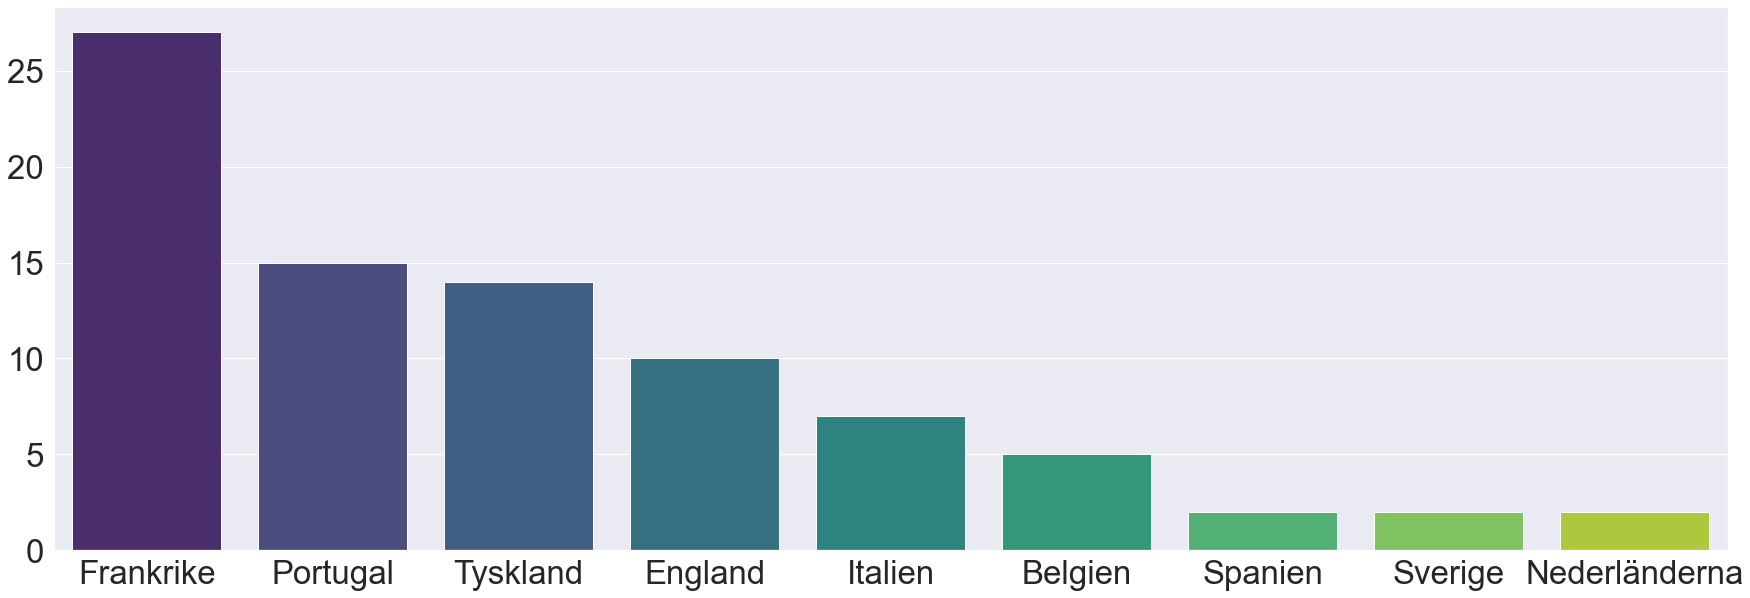

In [79]:
x = np.array(list(in_final_sorted.keys()))
y = np.array(list(in_final_sorted.values()))
dims = (30, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 3)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_final_plot")

In [47]:
in_semifinal = {}
for key in df.keys():
    semiTeams = df[key]['semifinals']
    for team in semiTeams:
        if team in in_semifinal:
            in_semifinal[team] += 1
        else:
            in_semifinal[team] = 1

In [78]:
in_semifinal_sorted = {k: v for k, v in sorted(in_semifinal.items(), key=lambda item: item[1], reverse=True)}

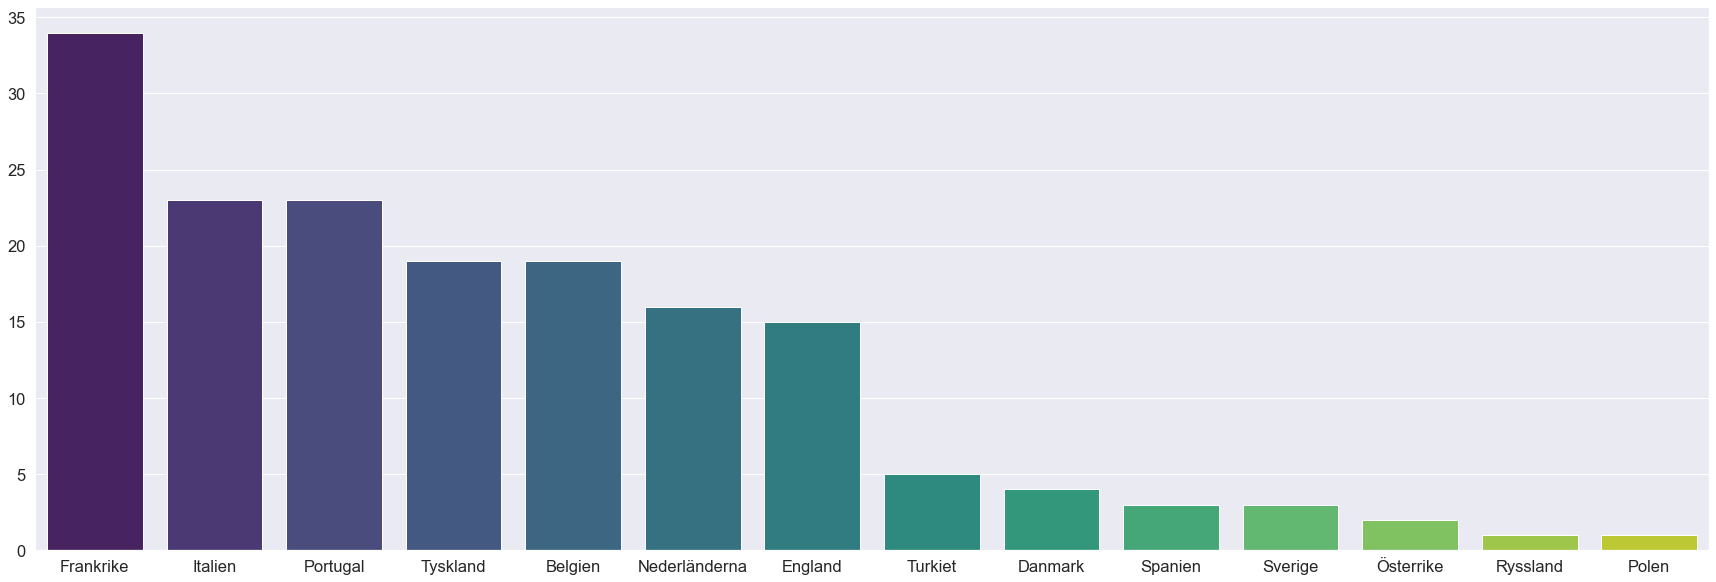

In [82]:
x = np.array(list(in_semifinal_sorted.keys()))
y = np.array(list(in_semifinal_sorted.values()))
dims = (30, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_semifinal_plot")

In [49]:
in_quarterfinal = {}
for key in df.keys():
    quarterTeams = df[key]['quarterfinals']
    for team in quarterTeams:
        if team in in_quarterfinal:
            in_quarterfinal[team] += 1
        else:
            in_quarterfinal[team] = 1

In [85]:
in_quarterfinal_sorted = {k: v for k, v in sorted(in_quarterfinal.items(), key=lambda item: item[1], reverse=True)}

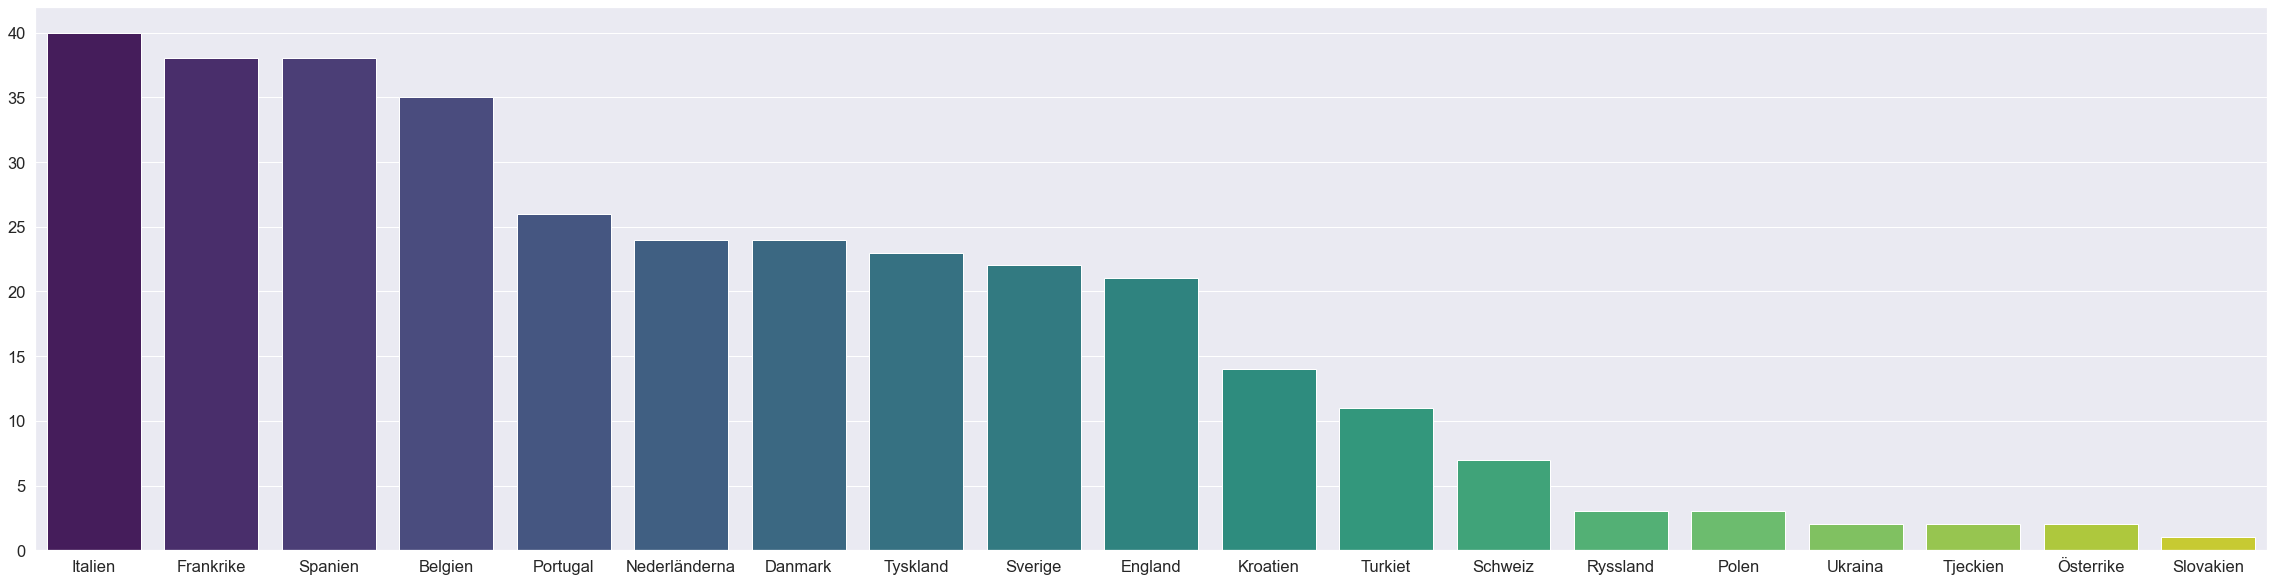

In [89]:
x = np.array(list(in_quarterfinal_sorted.keys()))
y = np.array(list(in_quarterfinal_sorted.values()))
dims = (40, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_quarterfinal_plot")

In [51]:
in_sixteen = {}
for key in df.keys():
    sixteenTeams = df[key]['roundofsixteen']
    for team in sixteenTeams:
        if team in in_sixteen:
            in_sixteen[team] += 1
        else:
            in_sixteen[team] = 1

In [90]:
in_sixteen_sorted = {k: v for k, v in sorted(in_sixteen.items(), key=lambda item: item[1], reverse=True)}

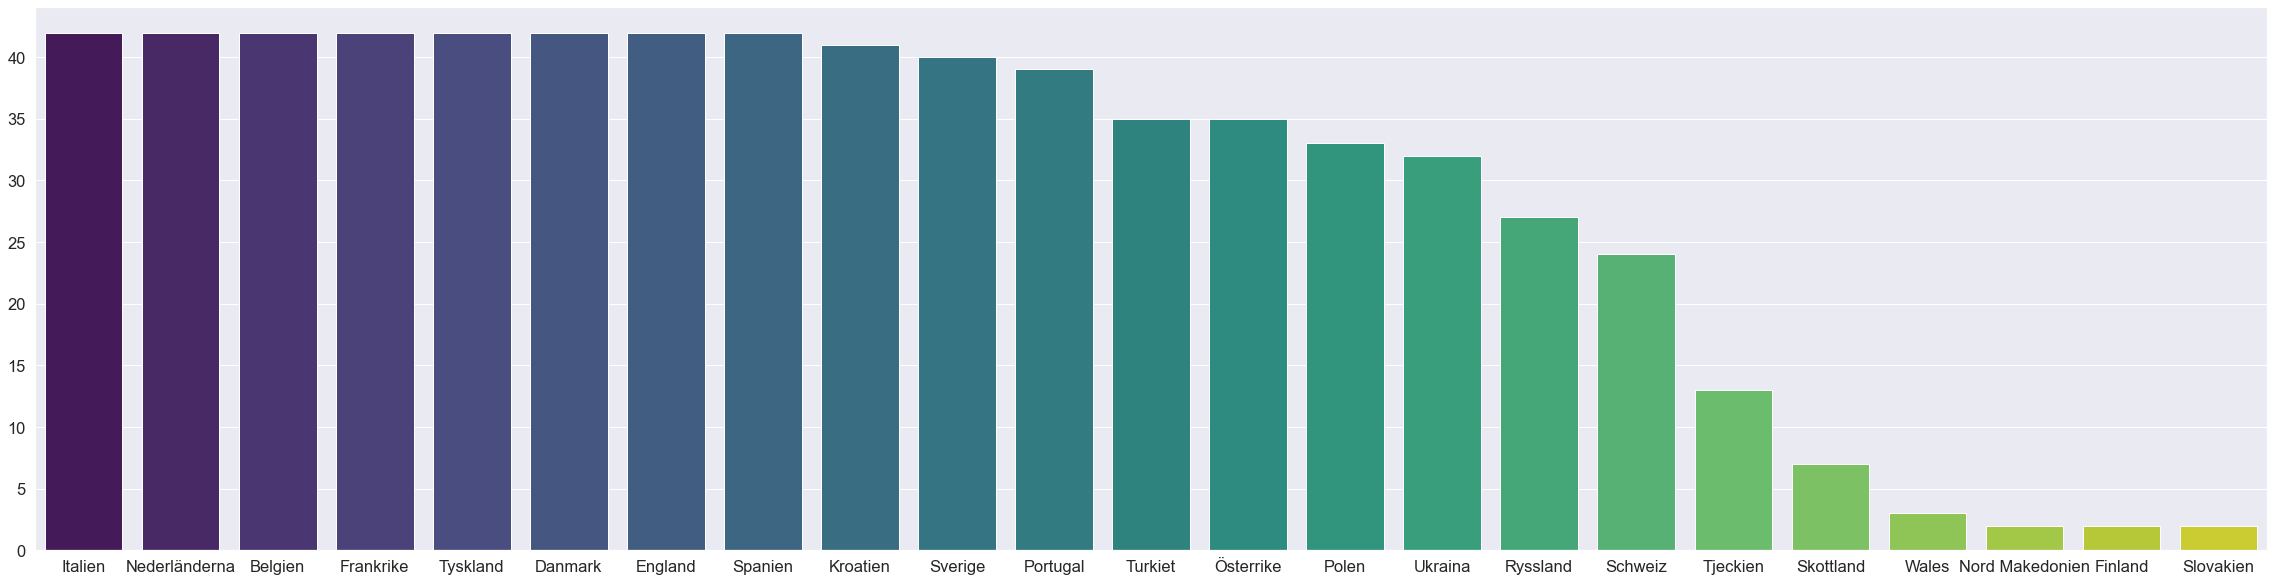

In [92]:
x = np.array(list(in_sixteen_sorted.keys()))
y = np.array(list(in_sixteen_sorted.values()))
dims = (40, 10)
fig, ax = plt.subplots(figsize=dims)
sns.set(font_scale = 1.5)
barp = sns.barplot(x=x, y=y, palette="viridis", ax=ax)
fig = barp.get_figure()
fig.savefig(dpi=300, fname="in_sixteen_plot")